In [2]:
using Plots, LaTeXStrings
gr()
using LinearAlgebra, Random, Distributions, Base.Threads, Distributed
@everywhere using SharedArrays 
addprocs(Sys.CPU_THREADS - 1)

┌ Info: Precompiling Distributions [31c24e10-a181-5473-b8eb-7969acd0382f]
└ @ Base loading.jl:1192


7-element Array{Int64,1}:
 2
 3
 4
 5
 6
 7
 8

In [3]:
# sample for a standard-normal distribution
d_diag = Normal()

Normal{Float64}(μ=0.0, σ=1.0)

In [4]:
rand(d_diag)

0.9509819874996983

The standard deviation $\sigma$ is square root of the variance. 
$\sigma^2 = Var[x]$. For the off-diagonal elements, we need a `variance`of $1/2$, which means a $\sigma = 1/\sqrt{2}$. 

In [5]:
d_offdiag = Normal(0.0, 1/sqrt(2))

Normal{Float64}(μ=0.0, σ=0.7071067811865475)

In [6]:
rand(d_offdiag)

0.9197921114837155

In [7]:
## This part is not working in multiple cpu's. So, the generation of random numbers will be performed old fashion. 

In [33]:
@everywhere function pointsDelaunay(dimBase::Float64, dim::Int64)
    points = rand(dim, 2)
    if dimBase != 1.0
        points[:,2] /= dimBase
    end
    n, tri = GR.delaunay(points[:,1], points[:,2])
    n, tri, points
end

@everywhere function triDelaunay(points)
    n, tri = GR.delaunay(points[:,1], points[:,2])
    n, tri, points
end

@everywhere function rcentersGeqOneLune(beta::Float64, x1::Float64, y1::Float64, x2::Float64, y2::Float64)
    c1 = [beta.*x1./2.0 .+ (1.0 .- beta./2).*x2 beta.*y1./2.0 .+ (1.0 .- beta./2.0).*y2]
    c2 = [(1.0 .- beta./2.0).*x1 .+ beta.*x2./2.0 (1.0 .- beta./2).*y1 .+ beta.*y2./2]
    r = beta.*sqrt((x2 .- x1).^2 + (y2 .- y1).^2)./2.0
    r, c1, c2
end

@everywhere function rcentersLeqOne(beta::Float64, x1::Float64, y1::Float64, x2::Float64, y2::Float64)
    dot_v1 = [x1, y1]
    dot_v2 = [x2, y2]
    vec_v1v2 = dot_v2 .- dot_v1
    rotvec = reverse(vec_v1v2).*[-1,1]
    radOut = sqrt.(sum(vec_v1v2.^2))./(2*beta)
    b_out = sqrt.(1 .- beta^2)./(2*beta)
    p_c1 = (dot_v1 .+ dot_v2)./2 .+ b_out.*rotvec
    p_c2 = (dot_v1 .+ dot_v2)./2 .- b_out.*rotvec
    radOut, p_c1', p_c2'
end

@everywhere function rcentersGeqOneCircle(beta::Float64, x1::Float64, y1::Float64, x2::Float64, y2::Float64)
    dot_v1 = [x1, y1]
    dot_v2 = [x2, y2]
    vec_v1v2 = dot_v2 .- dot_v1
    rotvec = reverse(vec_v1v2).*[-1,1]
    radOut = beta.*sqrt.(sum(vec_v1v2.^2))./2
    b_out = sqrt.(beta^2 .- 1)./2
    p_c1 = (dot_v1 .+ dot_v2)./2 .+ b_out.*rotvec
    p_c2 = (dot_v1 .+ dot_v2)./2 .- b_out.*rotvec
    radOut, p_c1', p_c2'
end


function betaRandSkeletonGeqOneLune(beta::Float64, dim::Int64, plotSkeleton = false, dimBase::Float64 = 1.0)
    n, tri, points = pointsDelaunay(dimBase, dim)
    mAdjacency = SharedArray{Float64}(diagm(0 => randn(dim)))
    indices = [1, 1, 2]
    j = [2, 3, 3]
    @sync @distributed for trindx in 1:n
        for (indx, i) in enumerate(indices)
            indx1 = tri[trindx,:][i]
            indx2 = tri[trindx,:][j[indx]]
            x1, y1 = points[indx1, :]
            x2, y2 = points[indx2, :]
            r, c1, c2 = rcentersGeqOneLune(beta, x1, y1, x2, y2)
            full_1 = sqrt.(sum((points .- c1).^2, dims = 2)) .< r
            full_2 = sqrt.(sum((points .- c2).^2, dims = 2)) .< r
            full_1[[indx1, indx2]] .= false
            if any(full_1 .+ full_2 .== 2) == false
                rnd = randn()./sqrt(2)
                mAdjacency[indx1, indx2] = rnd
                mAdjacency[indx2, indx1] = rnd  
            end
        end
    end
    plotSkeleton == true ? (mAdjacency, points, tri) : mAdjacency
end

function betaRandSkeletonGeqOneCircle(beta::Float64, dim::Int64, plotSkeleton = false, dimBase::Float64 = 1.0)
    n, tri, points = pointsDelaunay(dimBase, dim)
    mAdjacency = SharedArray{Float64}(diagm(0 => randn(dim)))
    indices = [1, 1, 2]
    j = [2, 3, 3]
    @sync @distributed for trindx in 1:n
        for (indx, i) in enumerate(indices)
            indx1 = tri[trindx,:][i]
            indx2 = tri[trindx,:][j[indx]]
            x1, y1 = points[indx1, :]
            x2, y2 = points[indx2, :]
            r, c1, c2 = rcentersGeqOneCircle(beta, x1, y1, x2, y2)
            full_1 = sqrt.(sum((points .- c1).^2, dims = 2)) .< r
            full_2 = sqrt.(sum((points .- c2).^2, dims = 2)) .< r
            full_1[[indx1, indx2]] .= false
            full_2[[indx1, indx2]] .= false
            if any(full_1 .| full_2) == false
                rnd = randn()./sqrt(2)
                mAdjacency[indx1, indx2] = rnd
                mAdjacency[indx2, indx1] = rnd  
            end
        end
    end
    plotSkeleton == true ? (mAdjacency, points, tri) : mAdjacency
end


function betaRandSkeletonLeqOne(beta::Float64, dim::Int64, plotSkeleton = false, dimBase::Float64 = 1.0)
    mAdjacency = SharedArray{Float64}(diagm(0 => randn(dim)))
    points = rand(dim, 2)
    if dimBase != 1.0
        points[:,2] /= dimBase
    end
    @sync @distributed for indx1 in 1:dim-1
        for indx2 in indx1 + 1:dim
            x1, y1 = points[indx1, :]
            x2, y2 = points[indx2, :]
            r, c1, c2 = rcentersLeqOne(beta, x1, y1, x2, y2)
            full_1 = sqrt.(sum((points .- c1).^2, dims = 2)) .< r
            full_2 = sqrt.(sum((points .- c2).^2, dims = 2)) .< r
            full_1[[indx1, indx2]] .= false
            if any(full_1 .+ full_2 .== 2) == false
                rnd = randn()./sqrt(2)
                mAdjacency[indx1, indx2] = rnd
                mAdjacency[indx2, indx1] = rnd  
            end
        end
    end    
    plotSkeleton == true ? (mAdjacency, points, tri) : mAdjacency
end

function betaSkeletonGeqOneLune(beta::Float64, points, plotSkeleton = false)
    n, tri, points = triDelaunay(points)
    dim = length(points[:,1])
    mAdjacency = SharedArray{Float64}(diagm(0 => randn(dim)))
    indices = [1, 1, 2]
    j = [2, 3, 3]
    @sync @distributed for trindx in 1:n
        for (indx, i) in enumerate(indices)
            indx1 = tri[trindx,:][i]
            indx2 = tri[trindx,:][j[indx]]
            x1, y1 = points[indx1, :]
            x2, y2 = points[indx2, :]
            r, c1, c2 = rcentersGeqOneLune(beta, x1, y1, x2, y2)
            full_1 = sqrt.(sum((points .- c1).^2, dims = 2)) .< r
            full_2 = sqrt.(sum((points .- c2).^2, dims = 2)) .< r
            full_1[[indx1, indx2]] .= false
            if any(full_1 .+ full_2 .== 2) == false
                rnd = randn()./sqrt(2)
                mAdjacency[indx1, indx2] = rnd
                mAdjacency[indx2, indx1] = rnd  
            end
        end
    end
    plotSkeleton == true ? (mAdjacency, points, tri) : mAdjacency
end

function betaSkeletonGeqOneCircle(beta::Float64, points, plotSkeleton = false)
    n, tri, points = triDelaunay(points)
    dim = length(points[:,1])
    mAdjacency = SharedArray{Float64}(diagm(0 => randn(dim)))
    indices = [1, 1, 2]
    j = [2, 3, 3]
    @sync @distributed for trindx in 1:n
        for (indx, i) in enumerate(indices)
            indx1 = tri[trindx,:][i]
            indx2 = tri[trindx,:][j[indx]]
            x1, y1 = points[indx1, :]
            x2, y2 = points[indx2, :]
            r, c1, c2 = rcentersGeqOneCircle(beta, x1, y1, x2, y2)
            full_1 = sqrt.(sum((points .- c1).^2, dims = 2)) .< r
            full_2 = sqrt.(sum((points .- c2).^2, dims = 2)) .< r
            full_1[[indx1, indx2]] .= false
            full_2[[indx1, indx2]] .= false
            if any(full_1 .| full_2) == false
                rnd = randn()./sqrt(2)
                mAdjacency[indx1, indx2] = 1.0
                mAdjacency[indx2, indx1] = 1.0 
            end
        end
    end
    plotSkeleton == true ? (mAdjacency, points, tri) : mAdjacency
end

function betaSkeletonLeqOne(beta::Float64, points)
    dim = length(points[:,1])
    mAdjacency = SharedArray{Float64}(diagm(0 => rand(dim)))
    @sync @distributed for indx1 in 1:dim-1
        for indx2 in indx1 + 1:dim
            x1, y1 = points[indx1, :]
            x2, y2 = points[indx2, :]
            r, c1, c2 = rcentersLeqOne(beta, x1, y1, x2, y2)
            full_1 = sqrt.(sum((points .- c1).^2, dims = 2)) .< r
            full_2 = sqrt.(sum((points .- c2).^2, dims = 2)) .< r
            full_1[[indx1, indx2]] .= false
            if any(full_1 .+ full_2 .== 2) == false
                rnd = randn()./sqrt(2)
                mAdjacency[indx1, indx2] = rnd
                mAdjacency[indx2, indx1] = rnd  
            end
        end
    end    
    mAdjacency
end


function plotBetaSkeleton(points, madjacency)
    x, y = points[:,1], points[:,2]
    lowerm = LowerTriangular(madjacency)
    n = length(x)
    p0 = plot(x, y,seriestype=:scatter, m=(2, 0.8, :black, stroke(0)),
        xlim =(0,1), ylim=(0,1), legend = false, grid = false, axis = :on, 
        framestyle=:box, xtickfont = font(14, "sans-serif"),ytickfont = font(14, "sans-serif"),
        xticks = ([0,1],[L"0",  L"1"]), yticks = ([0,1],[L"0", L"1"]),dpi=100,
        size = (300, 300), aspect_ratio=1)
    for indxp in 1:n
        edges = findall(lowerm[:,indxp] .!= 0)
        for v in edges[2:end]
            plot!(x[[indxp, v]], y[[indxp, v]], linewidth = 0.2, linecolor = :black)
        end
    end
    p0
end

function plotDelaunay(points, triplete)
    x, y = points[:,1], points[:,2]
    p1 = plot(xlim =(0,1), ylim=(0,1), legend = false, grid = false, axis = :on, 
        framestyle=:box,xtickfont = font(14, "sans-serif"),ytickfont = font(14, "sans-serif"),
        xticks = ([0,1],[L"0",  L"1"]), yticks = ([0,1],[L"0", L"1"]),
        size = (300, 300), aspect_ratio=1)
    for i in 1:size(tri)[1]
        plot!(x[triplete[i,:]], y[triplete[i,:]], seriestype = [:shape, :scatter], 
            m = (2, 0.2, :black, stroke(0)), linestyle = :solid,
            linealpha = 0.4, linewidth = 0.2, linecolor = :black, fillalpha = 0.06) #  fillcolor = :false
    end
    p1   
end

function pointsHexagonX(center, size, i)
    angledeg = 60*i #- 30
    anglerad = pi/180*angledeg
    (center[1] .+ size*cos(anglerad), center[2] .+ size*sin(anglerad))
end

pointsHexagonX (generic function with 1 method)

In [34]:
Random.seed!(1234)
madeaLune, points, tri = betaRandSkeletonGeqOneLune(1.0, 200, true);

In [35]:
madeaCircle = betaSkeletonGeqOneCircle(1.0, points);

In [36]:
madeafree = betaSkeletonLeqOne(1.0, points);

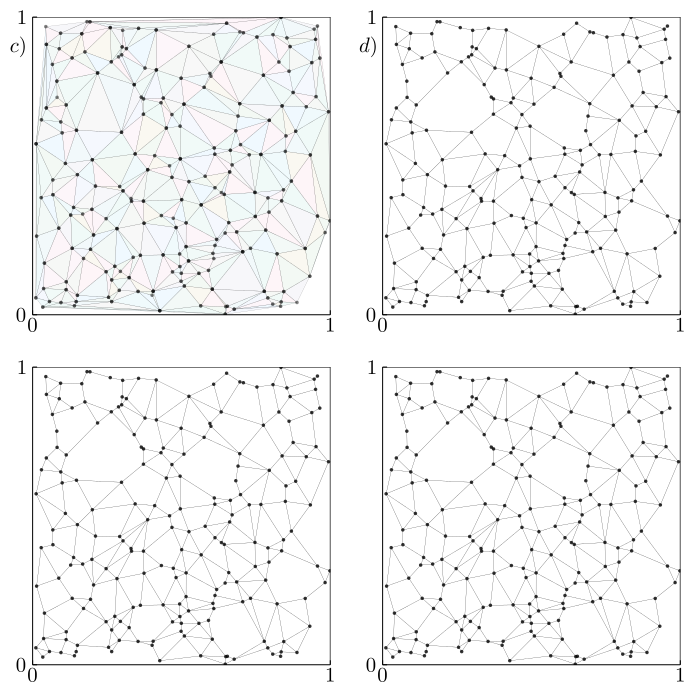

In [37]:
pSkeletonLune = plotBetaSkeleton(points, madeaLune)
annotate!(-0.05, 0.9, text(L"d)", :black, 14))
pSkeletonCircle = plotBetaSkeleton(points, madeaCircle)
pSkeletonfree = plotBetaSkeleton(points, madeafree)
pDelaunay = plotDelaunay(points, tri)
annotate!(-0.05, 0.9, text(L"c)", :black, 14))
plot(pDelaunay, pSkeletonLune,  pSkeletonCircle, pSkeletonfree,  layout = (2, 2), legend=false, size = (700, 700))

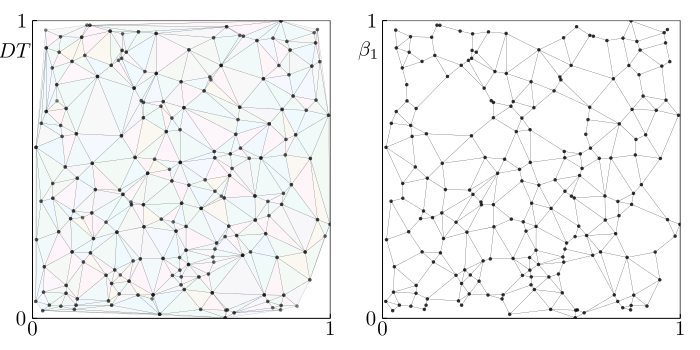

In [49]:
pSkeletonLune = plotBetaSkeleton(points, madeaLune)
annotate!(-0.05, 0.9, text(L"\beta_1", :black, 14))
#pSkeletonCircle = plotBetaSkeleton(points, madeaCircle)
#pSkeletonfree = plotBetaSkeleton(points, madeafree)
pDelaunay = plotDelaunay(points, tri)
annotate!(-0.06, 0.9, text(L"DT", :black, 14))
plot(pDelaunay, pSkeletonLune, layout = (1, 2), legend=false, size = (700, 350))
#savefig("randomSkeleton1Delauny.pdf")

In [51]:
803.63 -382.26 

421.37

In [52]:
2560 - 421.37

2138.63

In [53]:
2138.63 - 350

1788.63

In [57]:
1788.63 -816 -150

822.6300000000001

In [55]:
3115 * 22

68530

In [56]:
2560 -350

2210

In [13]:
# For beta_s = 1, the lune, circle-based definitions as well as the free definitions give exactly the same result. 

In [14]:
madeafreedot5 = betaSkeletonLeqOne(0.5, points)
madeaCircle1dot5 = betaSkeletonGeqOneCircle(1.5, points)
madeaLune1dot5 = betaSkeletonGeqOneLune(1.5, points);

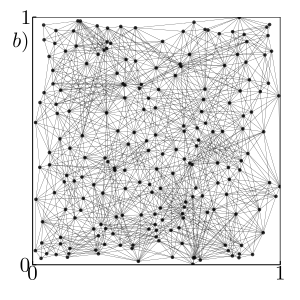

In [15]:
pSkeletonLune1dot5 = plotBetaSkeleton(points, madeaLune1dot5)
annotate!(-0.05, 0.9, text(L"a)", :black, 14));
pSkeletonCircle1dot5 = plotBetaSkeleton(points, madeaCircle1dot5)
annotate!(-0.05, 0.9, text(L"b)", :black, 14))
pSkeletonfreedot5 = plotBetaSkeleton(points, madeafreedot5)
annotate!(-0.05, 0.9, text(L"b)", :black, 14))

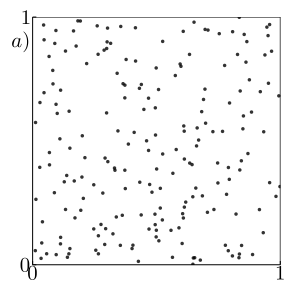

In [16]:
x, y = points[:,1], points[:,2]
randPoints = plot(x, y,seriestype=:scatter, m=(2, 0.8, :black, stroke(0)),
    xlim =(0,1), ylim=(0,1), legend = false, grid = false, axis = :on, 
    framestyle=:box, size = (300, 300), xtickfont = font(14, "sans-serif"),ytickfont = font(14, "sans-serif"),
    xticks = ([0,1],[L"0",  L"1"]), 
    yticks = ([0,1],[L"0", L"1"]),
    aspect_ratio=1, dpi=100)
randPoints
annotate!(-0.05, 0.9, text(L"a)", :black, 14))

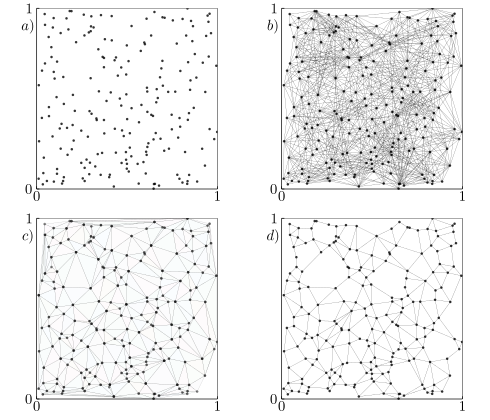

In [17]:
plot(randPoints, pSkeletonfreedot5, pDelaunay, pSkeletonLune,
    layout = (2, 2), legend=false, dpi=70, size = (700, 600))
#savefig("randomSkeleton1.pdf")

In [18]:
pSkeletonfreedot5 = plotBetaSkeleton(points, madeafreedot5)
annotate!(-0.05, 0.9, text(L"a)", :black, 14))
pSkeletonLune = plotBetaSkeleton(points, madeaLune)
annotate!(-0.05, 0.9, text(L"b)", :black, 14));

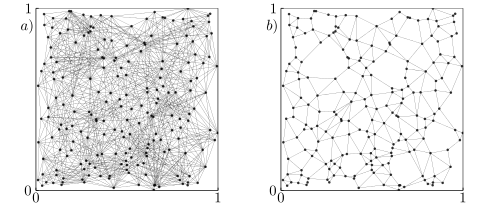

In [19]:
plot(pSkeletonfreedot5, pSkeletonLune,
    layout = (1, 2), legend=false, dpi=70, size = (700, 300))
#savefig("randomSkeletonLeq1.pdf")

In [20]:
madeaCircle2 = betaSkeletonGeqOneCircle(2.0, points)
madeaLune2 = betaSkeletonGeqOneLune(2.0, points);

In [21]:
pSkeletonLune2 = plotBetaSkeleton(points, madeaLune2)
annotate!(-0.05, 0.9, text(L"c)", :black, 14))
pSkeletonCircle2 = plotBetaSkeleton(points, madeaCircle2)
annotate!(-0.05, 0.9, text(L"d)", :black, 14));

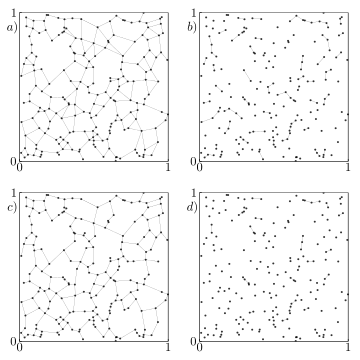

In [22]:
plot(pSkeletonLune1dot5, pSkeletonCircle1dot5, pSkeletonLune2,pSkeletonCircle2,
    layout = (2, 2), legend=false, dpi= 60, size = (600, 600))
#savefig("randomSkeleton2.pdf")

In [58]:
28.85 + 24.13

52.980000000000004